Worked with:
- Trevor Mathisen

- Viet Nguyen

1. Download startup failure dataset and its description.
2. Perform standard EDA to get familiar with the dataset.

In [51]:
import pandas as pd
from pandas import set_option
from pandas import read_csv
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold, cross_val_score
from numpy import set_printoptions, log, argmax
import numpy as np
import seaborn as sns
from pandas.plotting import scatter_matrix
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import precision_recall_curve, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import re


In [52]:
import os
dfs = []
for dirname, _, filenames in os.walk('datasets'):
    for filename in filenames:
        if '(' in filename and 'Food' not in filename:
            print(f'Loading {filename}...')
            df_temp = pd.read_csv(f'datasets/{filename}', encoding='utf-8')
            print(df_temp.shape)
            dfs.append(df_temp)

data = pd.concat(dfs, ignore_index=True)
set_printoptions(precision=3)
data = data.dropna()
print(data.isnull().sum())
print(data.shape)
# Display unique values in each column
for col in data.columns:
    unique_values = data[col].unique()
    print(f"Unique values in '{col}': {unique_values}")


Loading Startup Failure (Manufactures).csv...
(30, 20)
Loading Startup Failures (Information Sector).csv...
(156, 20)
Loading Startup Failure (Retail Trade).csv...
(90, 20)
Loading Startup Failure (Health Care).csv...
(60, 20)
Loading Startup Failure (Finance and Insurance).csv...
(47, 20)
Name                      0
Sector                    0
Years of Operation        0
What They Did             0
How Much They Raised      0
Why They Failed           0
Takeaway                  0
Giants                    0
No Budget                 0
Competition               0
Poor Market Fit           0
Acquisition Stagnation    0
Platform Dependency       0
Monetization Failure      0
Niche Limits              0
Execution Flaws           0
Trend Shifts              0
Toxicity/Trust Issues     0
Regulatory Pressure       0
Overhype                  0
dtype: int64
(382, 20)
Unique values in 'Name': ['Airware' 'Anki' 'Aptera Motors' 'Aria Insights' 'August Home'
 'BeagleBone' 'Better Place' 'Butterf

In [53]:
data = data.drop(columns=['Name', 'What They Did', 'Why They Failed', 'Takeaway'])
data['Overhype'] = data['Overhype'].astype(int)
binary_columns = ['Giants', 'No Budget', 'Competition', 'Poor Market Fit', 'Acquisition Stagnation', 'Platform Dependency', 'Monetization Failure', 'Niche Limits', 'Execution Flaws', 'Trend Shifts', 'Toxicity/Trust Issues', 'Regulatory Pressure', 'Overhype']
print(data.head(5))

          Sector Years of Operation How Much They Raised  Giants  No Budget  \
0  Manufacturing          2011-2018                 $70M       1          1   
1  Manufacturing          2010-2019                $200M       1          1   
2  Manufacturing          2005-2011                 $40M       1          0   
3  Manufacturing          2008-2019                 $39M       1          0   
4  Manufacturing          2012-2017                 $73M       1          0   

   Competition  Poor Market Fit  Acquisition Stagnation  Platform Dependency  \
0            1                0                       0                    0   
1            1                0                       0                    0   
2            1                1                       0                    0   
3            1                1                       0                    0   
4            1                0                       1                    0   

   Monetization Failure  Niche Limits  Execu

In [54]:
def parse_years(row):
    years_str = str(row)
    # Case 1: Format like "6 (2011-2017)"
    if '(' in years_str and ')' in years_str:
        lifespan = re.search(r'(\d+)\s*\(', years_str)
        founded = re.search(r'\((\d+)-', years_str)
        shutdown = re.search(r'-(\d+)\)', years_str)
        return (int(lifespan.group(1)) if lifespan else np.nan,
                int(founded.group(1)) if founded else np.nan,
                int(shutdown.group(1)) if shutdown else np.nan)
    # Case 2: Format like "2011-2017"
    elif '-' in years_str and '(' not in years_str:
        match = re.search(r'(\d+)-(\d+)', years_str)
        if match:
            founded, shutdown = int(match.group(1)), int(match.group(2))
            lifespan = shutdown - founded
            return lifespan, founded, shutdown
    return np.nan, np.nan, np.nan

# First create temporary columns for years
years_data = data['Years of Operation'].apply(parse_years).apply(pd.Series)
years_data.columns = ['Years of Operation', 'start_year', 'end_year']

# Update the dataframe with the parsed values
data['Years of Operation'] = years_data['Years of Operation']
# data['start_year'] = years_data['start_year']
# data['end_year'] = years_data['end_year']

In [55]:
# Clean Funding: Convert 'How Much They Raised' to numeric values in millions ($M)
def clean_funding(x):
    if pd.isna(x): return 0
    match = re.search(r'\$(\d*\.?\d+)([MB])', x)
    if match:
        value, unit = float(match.group(1)), match.group(2)
        return value * 1000 if unit == 'B' else value  # Convert billions to millions
    return 0
data['Funding ($M)'] = data['How Much They Raised'].apply(clean_funding)
data = data.drop(columns=['How Much They Raised'])

print(data.head(5))

          Sector  Years of Operation  Giants  No Budget  Competition  \
0  Manufacturing                   7       1          1            1   
1  Manufacturing                   9       1          1            1   
2  Manufacturing                   6       1          0            1   
3  Manufacturing                  11       1          0            1   
4  Manufacturing                   5       1          0            1   

   Poor Market Fit  Acquisition Stagnation  Platform Dependency  \
0                0                       0                    0   
1                0                       0                    0   
2                1                       0                    0   
3                1                       0                    0   
4                0                       1                    0   

   Monetization Failure  Niche Limits  Execution Flaws  Trend Shifts  \
0                     0             0                0             0   
1                   

## There's no need to perform this on the other numeric columns as they are binary and no distribution transformation is needed.

       Funding ($M)  Years of Operation
count    382.000000          382.000000
mean     161.022971            7.575916
std      394.164114            3.556554
min        0.000000            0.000000
25%        5.000000            5.000000
50%       29.250000            7.000000
75%      121.625000           10.000000
max     3600.000000           18.000000


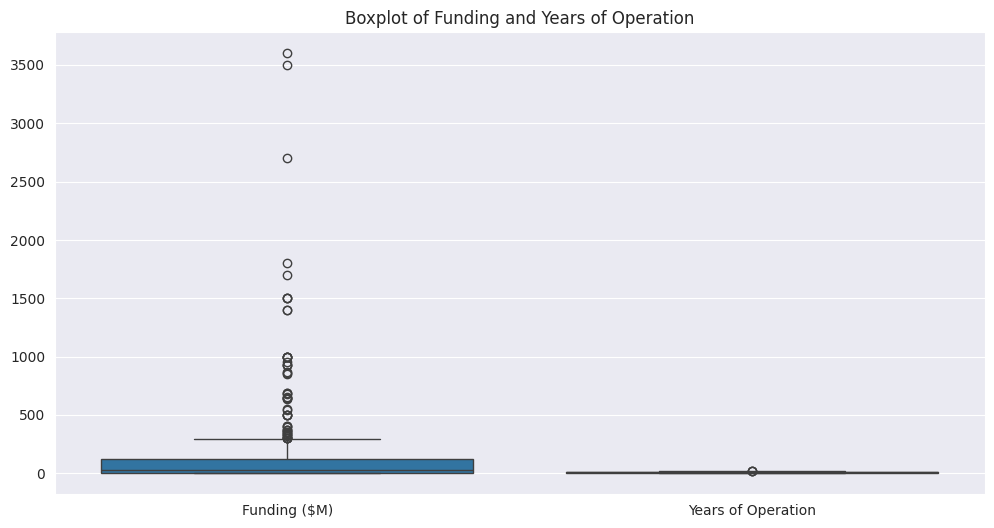

Skewness of Funding: 5.159243939703619
Skewness of Years of Operation: 0.6276991129508875


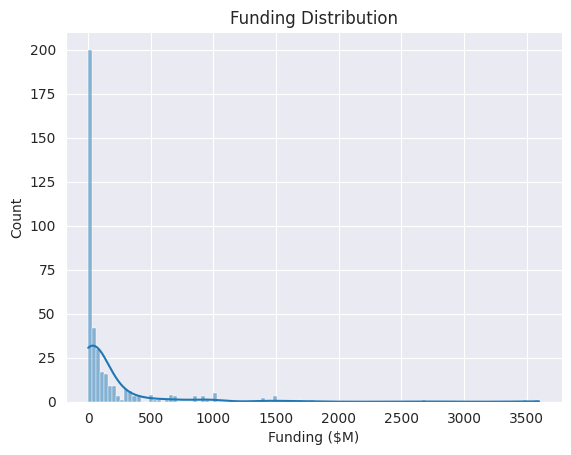

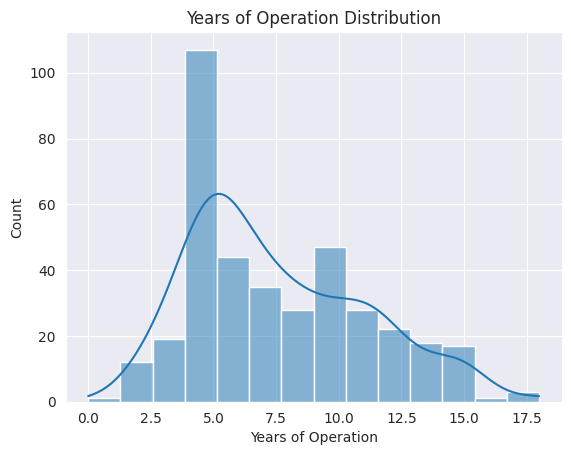

In [56]:
# Statistics on Funding and Years of Operation to determine if we need to normalize or standardize or nothing
print(data[['Funding ($M)', 'Years of Operation']].describe())
# Check for outliers in Funding and Years of Operation
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[['Funding ($M)', 'Years of Operation']])
plt.title('Boxplot of Funding and Years of Operation')
plt.show()
# Check for skewness
print("Skewness of Funding:", data['Funding ($M)'].skew())
print("Skewness of Years of Operation:", data['Years of Operation'].skew())
# Check for normality
sns.histplot(data['Funding ($M)'], kde=True)
plt.title('Funding Distribution')
plt.xlabel('Funding ($M)')
plt.show()
sns.histplot(data['Years of Operation'], kde=True)
plt.title('Years of Operation Distribution')
plt.xlabel('Years of Operation')
plt.show()

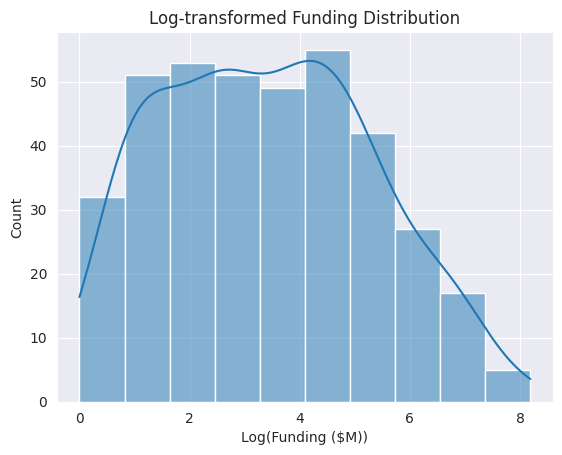

In [57]:
# Log transform funding, years of operation is fine
data['Funding ($M)'] = np.log1p(data['Funding ($M)'])
# Now show the distribution again
sns.histplot(data['Funding ($M)'], kde=True)
plt.title('Log-transformed Funding Distribution')
plt.xlabel('Log(Funding ($M))')
plt.show()

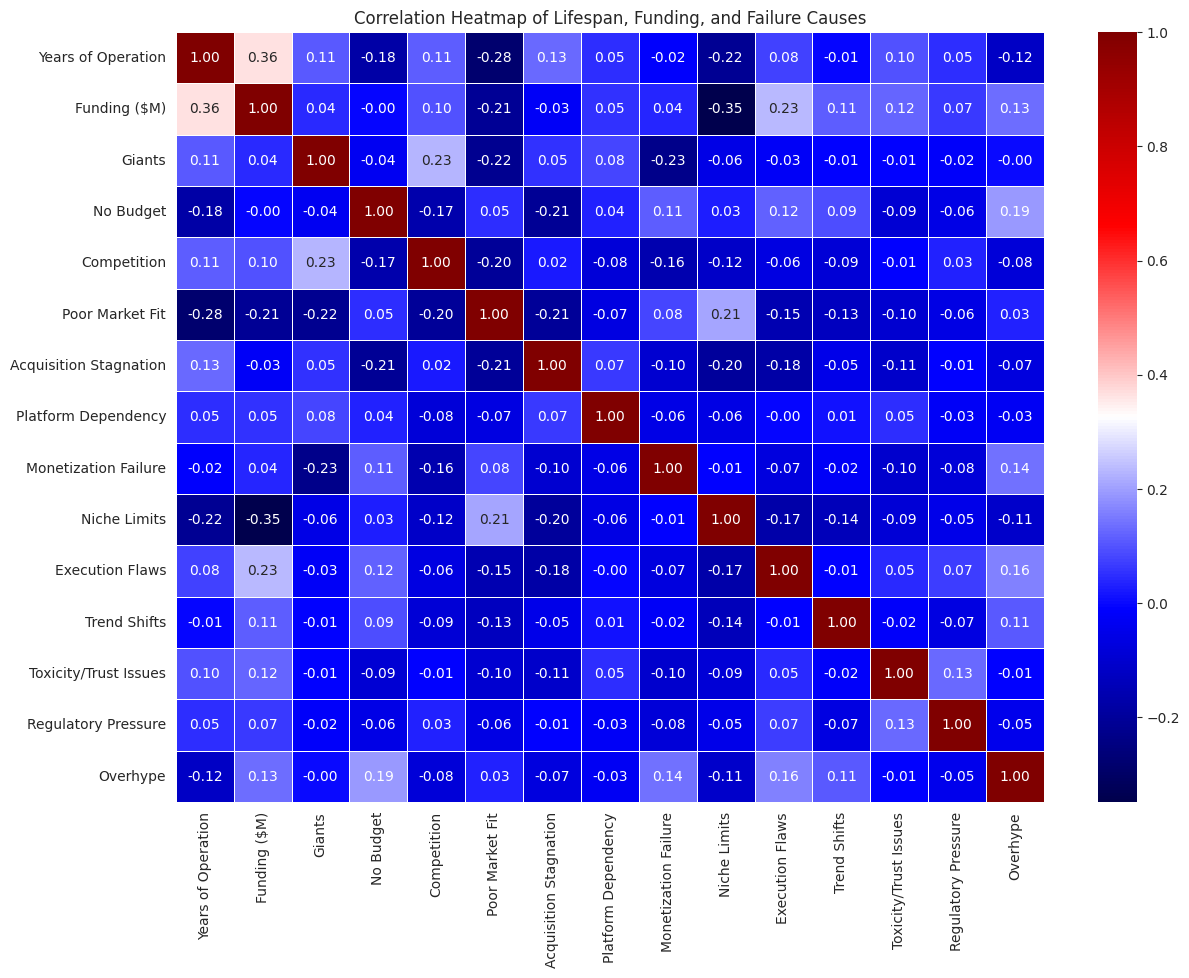

In [58]:
# Select columns for correlation
corr_cols = ['Years of Operation', 'Funding ($M)'] + binary_columns
corr_matrix = data[corr_cols].corr()
# Generate Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='seismic', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Lifespan, Funding, and Failure Causes')
plt.show()

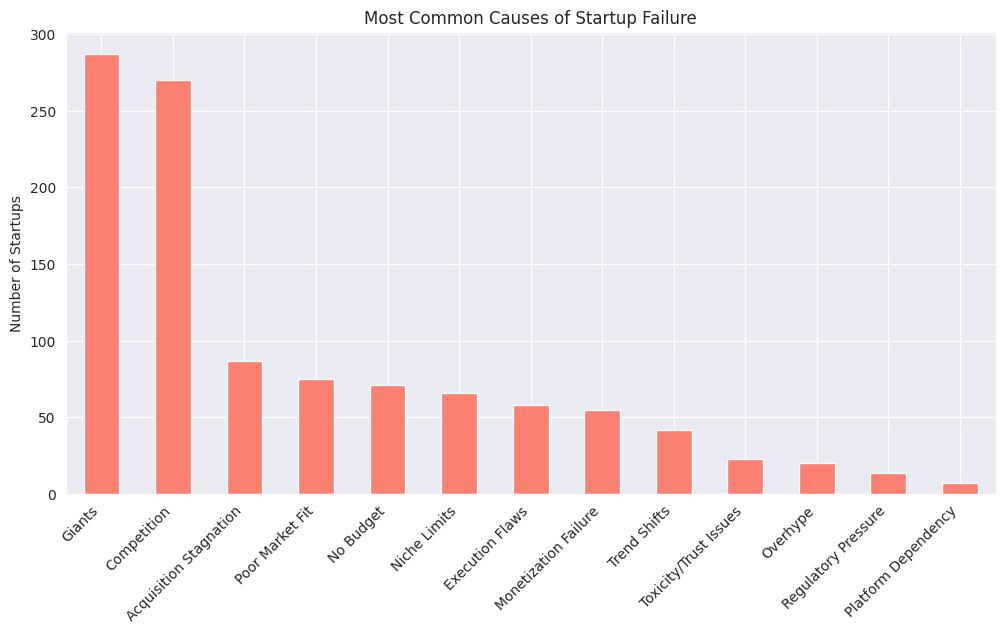

In [59]:
failure_sums = data[binary_columns].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
failure_sums.plot(kind='bar', color='salmon')
plt.title('Most Common Causes of Startup Failure')
plt.ylabel('Number of Startups')
plt.xticks(rotation=45, ha='right')
plt.show()


In [60]:
print(data.columns)
# Show unique data types within each column
for col in data.columns:
    unique_types = data[col].apply(type).unique()
    print(f"Unique data types in '{col}': {unique_types}")

Index(['Sector', 'Years of Operation', 'Giants', 'No Budget', 'Competition',
       'Poor Market Fit', 'Acquisition Stagnation', 'Platform Dependency',
       'Monetization Failure', 'Niche Limits', 'Execution Flaws',
       'Trend Shifts', 'Toxicity/Trust Issues', 'Regulatory Pressure',
       'Overhype', 'Funding ($M)'],
      dtype='object')
Unique data types in 'Sector': [<class 'str'>]
Unique data types in 'Years of Operation': [<class 'int'>]
Unique data types in 'Giants': [<class 'int'>]
Unique data types in 'No Budget': [<class 'int'>]
Unique data types in 'Competition': [<class 'int'>]
Unique data types in 'Poor Market Fit': [<class 'int'>]
Unique data types in 'Acquisition Stagnation': [<class 'int'>]
Unique data types in 'Platform Dependency': [<class 'int'>]
Unique data types in 'Monetization Failure': [<class 'int'>]
Unique data types in 'Niche Limits': [<class 'int'>]
Unique data types in 'Execution Flaws': [<class 'int'>]
Unique data types in 'Trend Shifts': [<class 'int

In [61]:
one_hot = pd.get_dummies(data['Sector'], prefix='Sector', dtype=int)
data = pd.concat([data, one_hot], axis=1)
data = data.drop(columns=['Sector'])
print(data.columns)
print(data.head(5))

Index(['Years of Operation', 'Giants', 'No Budget', 'Competition',
       'Poor Market Fit', 'Acquisition Stagnation', 'Platform Dependency',
       'Monetization Failure', 'Niche Limits', 'Execution Flaws',
       'Trend Shifts', 'Toxicity/Trust Issues', 'Regulatory Pressure',
       'Overhype', 'Funding ($M)', 'Sector_Finance and Insurance',
       'Sector_Health Care', 'Sector_Information', 'Sector_Manufacturing',
       'Sector_Retail Trade'],
      dtype='object')
   Years of Operation  Giants  No Budget  Competition  Poor Market Fit  \
0                   7       1          1            1                0   
1                   9       1          1            1                0   
2                   6       1          0            1                1   
3                  11       1          0            1                1   
4                   5       1          0            1                0   

   Acquisition Stagnation  Platform Dependency  Monetization Failure  \
0        

3. Use the sample code for the Ensemble classifier and modify it to work with the Startup
dataset.

In [70]:
print(data.columns)
# output_variable = 'Years of Operation' # Accuracy = 0.2
# output_variable = 'Funding ($M)' # Accuracy = unable, regression problem
# output_variable = 'Overhype' # Accuracy = 0.96
output_variable = 'Poor Market Fit' # Accuracy =
X = data.drop(output_variable, axis=1)
Y = data[output_variable]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Index(['Years of Operation', 'Giants', 'No Budget', 'Competition',
       'Poor Market Fit', 'Acquisition Stagnation', 'Platform Dependency',
       'Monetization Failure', 'Niche Limits', 'Execution Flaws',
       'Trend Shifts', 'Toxicity/Trust Issues', 'Regulatory Pressure',
       'Overhype', 'Funding ($M)', 'Sector_Finance and Insurance',
       'Sector_Health Care', 'Sector_Information', 'Sector_Manufacturing',
       'Sector_Retail Trade'],
      dtype='object')


4. Compare the performance a decision tree, bagging classifier, random forest and a
boosting classifier using all default settings and configuration used in the sample code.

Bagging Classifier Accuracy: 0.8571
Decision Tree Classifier Accuracy: 0.7532
Random Forest Classifier Accuracy: 0.8182
AdaBoost Classifier Accuracy: 0.8442


/tmp/ipykernel_8511/772700304.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=methods, y=accuracies, palette="viridis")


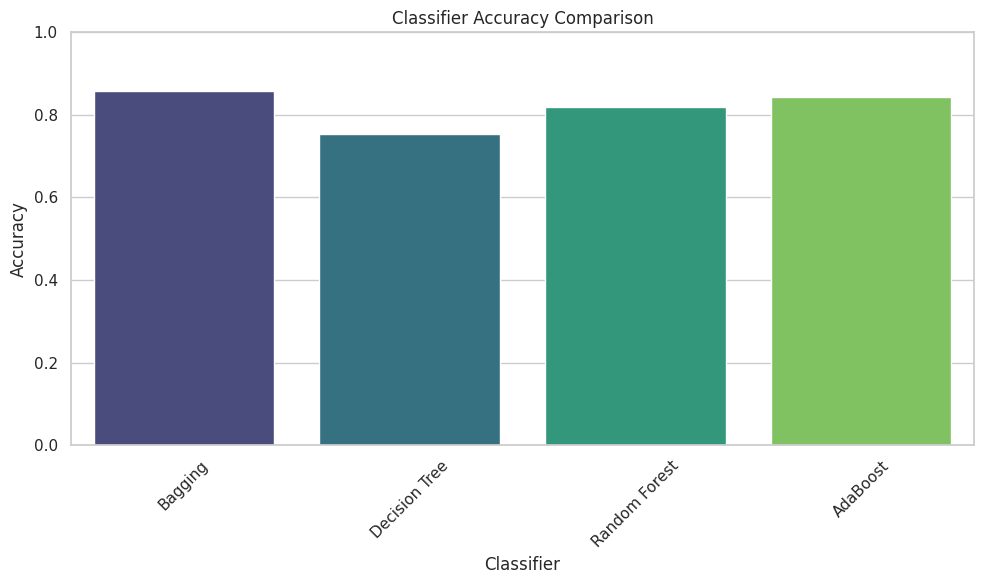

In [71]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
# And regression versions of each
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, random_state=40)
bag_clf.fit(X_train, Y_train)
bag_y_pred = bag_clf.predict(X_test)


dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, Y_train)
dt_y_pred = dt_clf.predict(X_test)

rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rf_clf.fit(X_train, Y_train)
rf_y_pred = rf_clf.predict(X_test)
rf_y_prob = rf_clf.predict_proba(X_test)

ab_clf = AdaBoostClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    learning_rate=1.0, random_state=42)
ab_clf.fit(X_train, Y_train)
ab_y_pred = ab_clf.predict(X_test)

# Calculate and plot the accuracy scores
bag_accuracy = accuracy_score(Y_test, bag_y_pred)
dt_accuracy = accuracy_score(Y_test, dt_y_pred)
rf_accuracy = accuracy_score(Y_test, rf_y_pred)
ab_accuracy = accuracy_score(Y_test, ab_y_pred)
print(f"Bagging Classifier Accuracy: {bag_accuracy:.4f}")
print(f"Decision Tree Classifier Accuracy: {dt_accuracy:.4f}")
print(f"Random Forest Classifier Accuracy: {rf_accuracy:.4f}")
print(f"AdaBoost Classifier Accuracy: {ab_accuracy:.4f}")

# Plotting the accuracies
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set the style
sns.set(style="whitegrid")
# Data for plotting
methods = ['Bagging', 'Decision Tree', 'Random Forest', 'AdaBoost']
accuracies = [bag_accuracy, dt_accuracy, rf_accuracy, ab_accuracy]

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=methods, y=accuracies, palette="viridis")
plt.title('Classifier Accuracy Comparison')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


5. Modify the random forest classifier tree depth hyper-parameter for the depth of 2-7 and analyze and comment on the results of the impact of changing the tree depth on the performance (replace the max_leaf_nodes=16 with max_depth = 2 (change from 2-7) ).

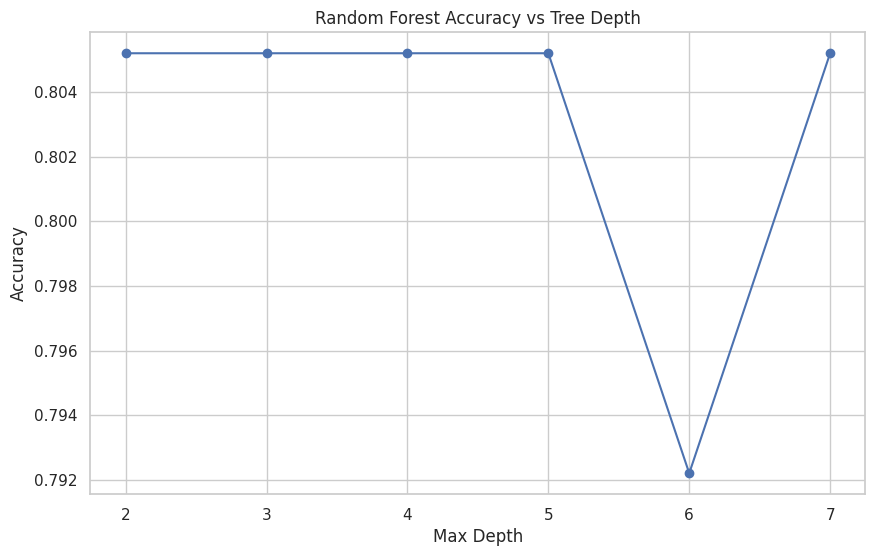

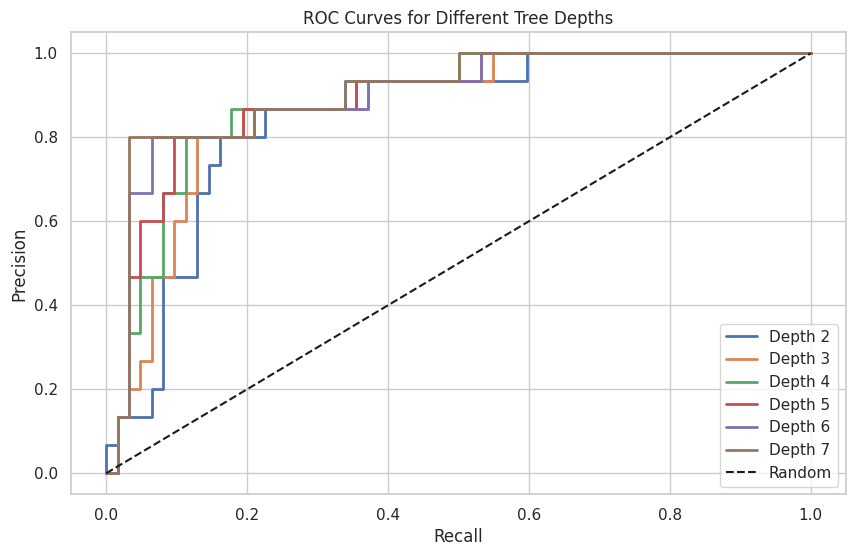

In [72]:
depths = list(range(2, 8))
accuracies = []
roc_curves = []

for depth in depths:
    rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=depth, n_jobs=-1, random_state=42)
    rf_clf.fit(X_train, Y_train)

    rf_y_pred = rf_clf.predict(X_test)
    accuracy = accuracy_score(Y_test, rf_y_pred)
    accuracies.append(accuracy)

    rf_y_prob = rf_clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(Y_test, rf_y_prob)
    roc_curves.append((fpr, tpr))

plt.figure(figsize=(10, 6))

# Plot accuracy vs depth
plt.plot(depths, accuracies, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy vs Tree Depth')
plt.grid(True)
plt.show()

# Plot ROC curves
plt.figure(figsize=(10, 6))
for i, depth in enumerate(depths):
    fpr, tpr = roc_curves[i]
    plt.plot(fpr, tpr, linewidth=2, label=f'Depth {depth}')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('ROC Curves for Different Tree Depths')
plt.legend()
plt.grid(True)
plt.show()

In [73]:
print("\nAccuracy scores for different tree depths:")
for depth, accuracy in zip(depths, accuracies):
    print(f"Max Depth {depth}: {accuracy:.4f}")

optimal_depth = depths[np.argmax(accuracies)]
print(f"\nOptimal tree depth: {optimal_depth} with accuracy: {max(accuracies):.4f}")


Accuracy scores for different tree depths:
Max Depth 2: 0.8052
Max Depth 3: 0.8052
Max Depth 4: 0.8052
Max Depth 5: 0.8052
Max Depth 6: 0.7922
Max Depth 7: 0.8052

Optimal tree depth: 2 with accuracy: 0.8052


Random Forest is highly stable, staying within the range of 0.8 and 0.9 accuracy score. The dataset is quite small, limiting the overall variability and resulting in step-like ROC curves.

6. For the Adaboost classifier, modify the learning rate to a higher rate and a low rate and analyze and comment on the results (you need to experiment with the learning rate to figure out what range makes sense).

<Figure size 1000x600 with 0 Axes>

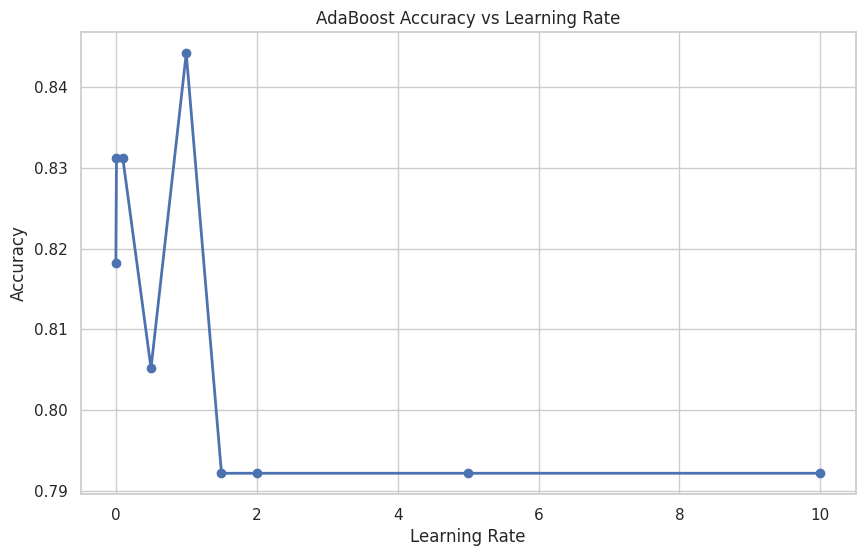

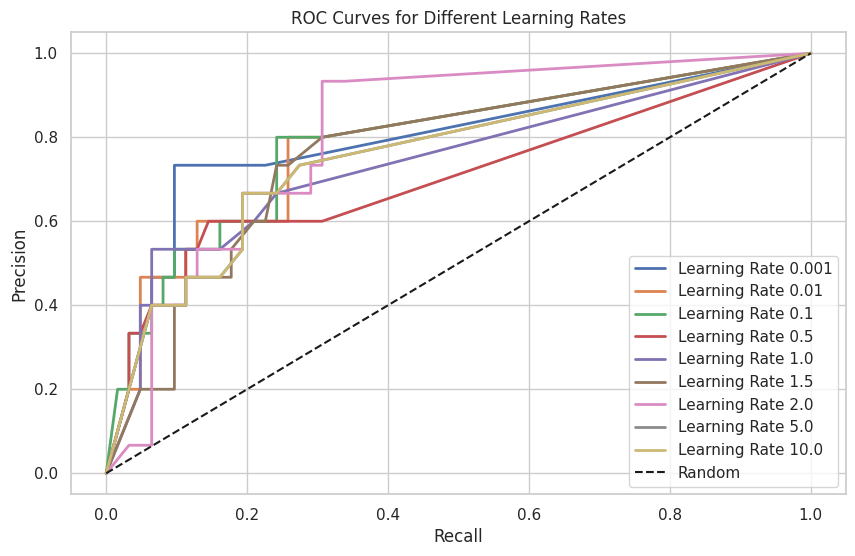

In [74]:
rates = [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0]
accuracies = []
roc_curves = []

for rate in rates:
    ab_clf = AdaBoostClassifier(DecisionTreeClassifier(random_state=42), n_estimators=500, learning_rate=rate, random_state=42)
    ab_clf.fit(X_train, Y_train)

    ab_y_pred = ab_clf.predict(X_test)
    accuracy = accuracy_score(Y_test, ab_y_pred)
    accuracies.append(accuracy)

    ab_y_prob = ab_clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(Y_test, ab_y_prob)
    roc_curves.append((fpr, tpr))

plt.figure(figsize=(10, 6))

# Plot accuracy vs depth
plt.figure(figsize=(10, 6))
plt.plot(rates, accuracies, marker='o', linewidth=2)
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('AdaBoost Accuracy vs Learning Rate')
plt.grid(True)
plt.show()

# Plot ROC curves
plt.figure(figsize=(10, 6))
for i, lr in enumerate(rates):
    fpr, tpr = roc_curves[i]
    plt.plot(fpr, tpr, linewidth=2, label=f'Learning Rate {lr}')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('ROC Curves for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()

In [75]:
print("\nAccuracy scores for different learning rates:")
for lr, accuracy in zip(rates, accuracies):
    print(f"Learning Rate {lr:.3f}: {accuracy:.4f}")

optimal_lr = rates[np.argmax(accuracies)]
print(f"\nOptimal learning rate: {optimal_lr:.3f} with accuracy: {max(accuracies):.4f}")


Accuracy scores for different learning rates:
Learning Rate 0.001: 0.8182
Learning Rate 0.010: 0.8312
Learning Rate 0.100: 0.8312
Learning Rate 0.500: 0.8052
Learning Rate 1.000: 0.8442
Learning Rate 1.500: 0.7922
Learning Rate 2.000: 0.7922
Learning Rate 5.000: 0.7922
Learning Rate 10.000: 0.7922

Optimal learning rate: 1.000 with accuracy: 0.8442


AdaBoost shows consistent result for varying learning rates. It strongly indicates that the small dataset contains very clear decision boundaries that are easily captured by the AdaBoost classifier, making the learning rate essentially irrelevant for this particular classification task.

7. Compare the performance of all models (all in steps 2-4) once again this time using cross-validation. Analyze the results and compare with the manual approach (steps 2-4)

In [76]:
def evaluate_each_model_in_turn(models, X, Y):
    results = []
    names = []
    scoring = 'accuracy'
    
    # Perform k-fold validation for each model
    for name, model in models.items():  # Changed from models to models.items()
        kfold = KFold(n_splits=10, random_state=42, shuffle=True)
        cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        print(f"{name}: {cv_results.mean():.4f} (±{cv_results.std()*2:.4f})")
    
    # Create boxplot comparison
    plt.figure(figsize=(10, 6))
    plt.boxplot(results, labels=names)
    plt.title('Cross-Validation Model Comparison')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return dict(zip(names, [{'mean': r.mean(), 'std': r.std()} for r in results]))

In [ ]:
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Bagging': BaggingClassifier(
        DecisionTreeClassifier(random_state=42), 
        n_estimators=500,
        bootstrap=True, 
        n_jobs=-1, 
        random_state=40
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=500, 
        max_leaf_nodes=16, 
        n_jobs=-1, 
        random_state=42
    ),
    'AdaBoost': AdaBoostClassifier(
        DecisionTreeClassifier(random_state=42),
        n_estimators=500,
        learning_rate=1.0, 
        random_state=42
    )
}

# Use the function with your existing classifiers
cv_results = evaluate_each_model_in_turn(models, X, Y)

# Compare with previous non-CV results
comparison_df = pd.DataFrame({
    'Non-CV Accuracy': {
        'Decision Tree': dt_accuracy,
        'Bagging': bag_accuracy,
        'Random Forest': rf_accuracy,
        'AdaBoost': ab_accuracy
    },
    'CV Mean Accuracy': {name: results['mean'] for name, results in cv_results.items()},
    'CV Std Dev': {name: results['std'] for name, results in cv_results.items()}
})

print("\nComparison with previous non-CV results:")
print(comparison_df.round(4))

Decision Tree: 0.8167 (±0.1308)
Bagging: 0.8559 (±0.1209)
Random Forest: 0.8194 (±0.1038)
